In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

device='cuda:0' if torch.cuda.is_available() else 'cpu'

device, torch.__version__

('cpu', '2.1.0+cu121')

torch.Size([800, 2]) torch.Size([800])


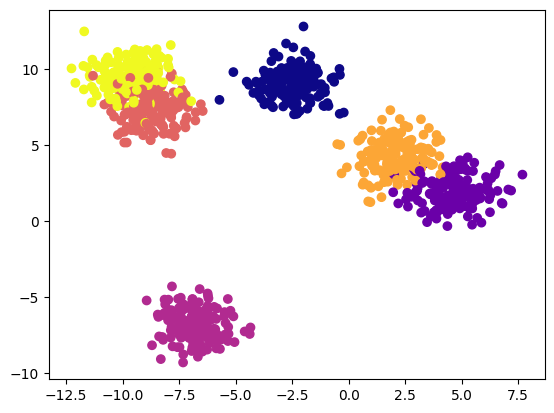

In [ ]:
#classifier hyperparams
NUM_CLASSES = 6
NUM_FEATURES = 2
RAND_SEED = 42

#create multiclass data
X, y = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=0.99, random_state=RAND_SEED)

#turn data into tensors
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float32)

#split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=RAND_SEED)

X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)
print(X_train.shape, y_train.shape)
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap='plasma')
plt.show()


In [ ]:
import requests
from pathlib import Path

#download helper functions from repo if not already downloaded
if Path("helper_functions.py").is_file():
  print("helper_function.py exists already in file path!")
else:
  print("Downloading helper_functions.py...")
  request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_function.py exists already in file path!


In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_neurons):
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
                            nn.Linear(in_features=input_features, out_features=hidden_neurons),
                            nn.ReLU(),
                            nn.Linear(in_features=hidden_neurons, out_features=hidden_neurons),
                            nn.ReLU(),
                            nn.Linear(in_features=hidden_neurons, out_features=output_features))
  def forward(self, x: torch.Tensor)->torch.Tensor:
    return self.linear_layer_stack(x)

model_5 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_neurons=16).to(device)
model_5

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=6, bias=True)
  )
)

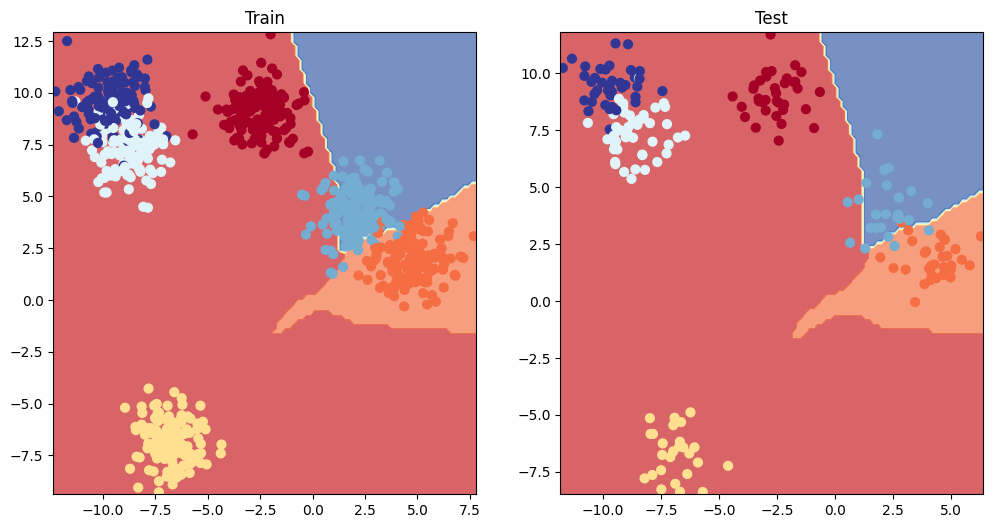

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_5, X_test, y_test)

In [ ]:
#Cross-Entropy Loss very good for multiclass classification

loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_5.parameters(), lr=0.1)

#accuracy function
def accuracy(y_test, y_preds):
  correct=torch.eq(y_test, y_preds).sum().item()
  return (correct/len(y_preds)) * 100

In [ ]:
#use softmax for multiclass classification
torch.manual_seed(42)
epochs=9941
for epoch in range(epochs):
  model_5.train()

  y_logits = model_5(X_train).squeeze()
  y_preds = torch.softmax(input=y_logits, dim=1).argmax(dim=1)
  loss=loss_func(y_logits, y_train.type(torch.LongTensor))
  acc=accuracy(y_test=y_train, y_preds=y_preds)
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_5.eval()

  with torch.inference_mode():
    test_logits=model_5(X_test).squeeze()
    test_preds=torch.softmax(input=test_logits, dim=1).argmax(dim=1)

    test_loss=loss_func(test_logits, y_test.type(torch.LongTensor))
    test_acc=accuracy(y_test=y_test, y_preds=test_preds)
  if(epoch%10==0):
    print(f"Epoch #{epoch} -- Training Loss: {loss}, Testing Loss: {test_loss}, Training Accuracy: {acc}%, Testing Accuracy: {test_acc}%")


Epoch #0 -- Training Loss: 1.7487901449203491, Testing Loss: 1.44187331199646, Training Accuracy: 32.25%, Testing Accuracy: 34.5%
Epoch #10 -- Training Loss: 0.8666679263114929, Testing Loss: 0.8192762732505798, Training Accuracy: 67.25%, Testing Accuracy: 65.5%
Epoch #20 -- Training Loss: 0.6000735759735107, Testing Loss: 0.589688241481781, Training Accuracy: 71.375%, Testing Accuracy: 76.5%
Epoch #30 -- Training Loss: 0.5376662611961365, Testing Loss: 0.533248245716095, Training Accuracy: 81.5%, Testing Accuracy: 79.0%
Epoch #40 -- Training Loss: 0.435703843832016, Testing Loss: 0.46122506260871887, Training Accuracy: 82.75%, Testing Accuracy: 79.0%
Epoch #50 -- Training Loss: 0.3840254843235016, Testing Loss: 0.4191415309906006, Training Accuracy: 83.125%, Testing Accuracy: 79.0%
Epoch #60 -- Training Loss: 0.3499811589717865, Testing Loss: 0.3908894658088684, Training Accuracy: 83.125%, Testing Accuracy: 79.0%
Epoch #70 -- Training Loss: 0.32546111941337585, Testing Loss: 0.3709102

Testing accuracy: 0.9350000023841858
Training accuracy: 0.9449999928474426


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

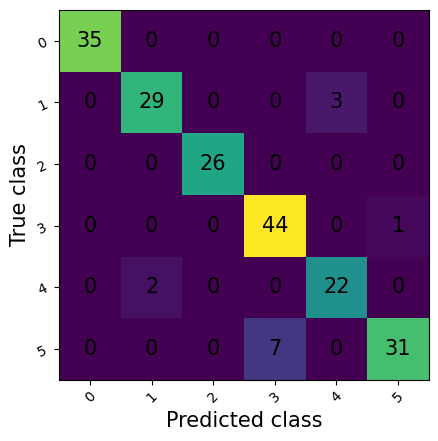

In [ ]:
from torchmetrics import Accuracy, ConfusionMatrix
torchmetric_accuracy=Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)
tm_cm=ConfusionMatrix(task='multiclass', num_classes=NUM_CLASSES)
tm_cm(test_preds, y_test)
print("Testing accuracy:",torchmetric_accuracy(test_preds, y_test).item())
print("Training accuracy:",torchmetric_accuracy(y_preds, y_train).item())
tm_cm.plot()
#pretty good performance considering 6 classes and simple model!

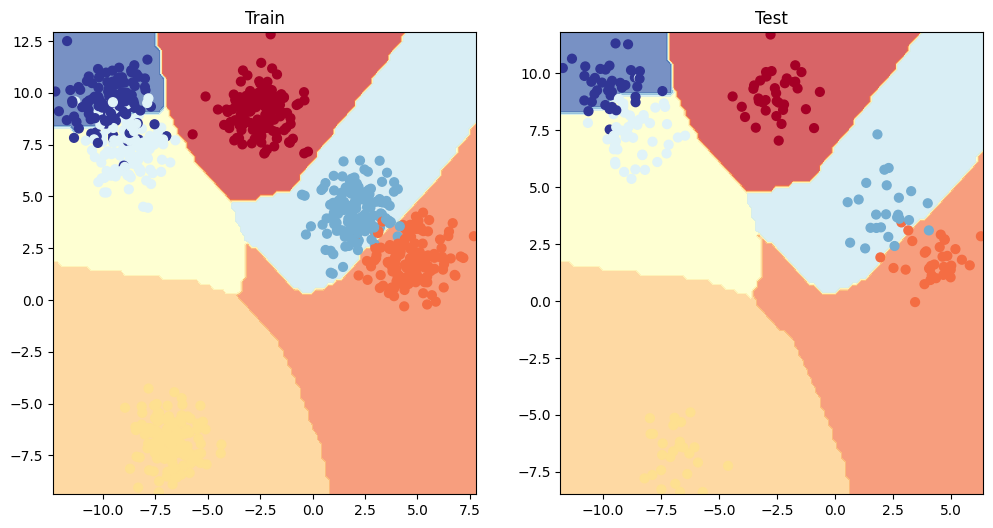

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_5, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_5, X_test, y_test)